In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import ast, json
from datetime import datetime
import matplotlib.pyplot as plt
from textblob import TextBlob
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import cv2
import glob
from PIL import Image

Using TensorFlow backend.


In [2]:
def get_images(metadata,basepath):
    train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1) # set validation split

    train_generator = train_datagen.flow_from_dataframe(dataframe=metadata,
    directory=basepath,
    x_col="filename",
    y_col="survival",
    target_size=(64, 64),
    batch_size=50,
    has_ext=True,
    class_mode='categorical',
    subset='training') # set as training data

    validation_generator = train_datagen.flow_from_dataframe(dataframe=metadata,
    directory=basepath,
    x_col="filename",
    y_col='survival',
    target_size=(64, 64),
    batch_size=50,
    class_mode='categorical',
    subset='validation') # set as training data
    return train_generator,validation_generator

In [110]:
def get_dataframes(path_to_csv):
    metadata=pd.read_csv(path_to_csv)
    labeled_df=metadata[metadata['survival'].notnull()]
    unlabeled_df=metadata[metadata['survival'].isnull()]
    return metadata,labeled_df,unlabeled_df

In [43]:
def get_validation_image(metadata,basepath):
    val_datagen=ImageDataGenerator(rescale=1./255.)
    val_generator=val_datagen.flow_from_dataframe(
    dataframe=metadata,
    directory=basepath,
    x_col='filename',
    y_col=None,
    has_ext=True,
    batch_size=50,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(64,64))
    return val_generator

In [113]:
def create_model():
    convo=Sequential()
    convo.add(Conv2D(32,(3,3),activation="relu",input_shape=(64,64,3)))
    convo.add(MaxPool2D(pool_size=(2,2)))
    convo.add(Conv2D(32,(3,3),activation="relu"))
    convo.add(MaxPool2D(pool_size = (2,2)))
    convo.add(Flatten())
    convo.add(Dense(activation = 'relu', units = 128))
    convo.add(Dense(2,activation = 'softmax'))
    convo.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return convo

In [114]:
metadata,labeled_df,unlabeled_df=get_dataframes("548681_1157383_bundle_archive/metadata.csv")
basepath="C:/Users/dhrupal/covid_hack/548681_1157383_bundle_archive/images/"
train_images,test_images=get_images(labeled_df,basepath)

Found 93 validated image filenames belonging to 2 classes.
Found 23 validated image filenames belonging to 2 classes.


Text(0.5, 1.0, 'COVID-19 Infected - Survival - No')

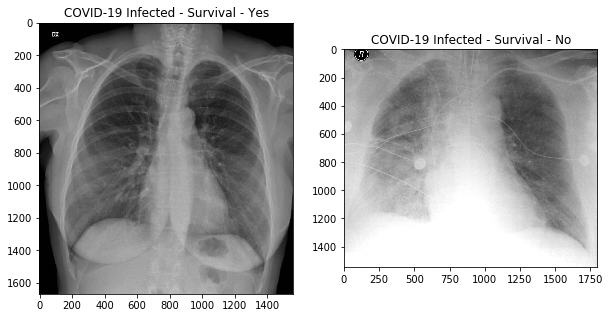

In [158]:
'''
Displaying Images
'''
positive_xray=labeled_df[labeled_df['survival']=='Y']
negative_xray=labeled_df[labeled_df['survival']=='N']
sample_positive_img_path=basepath+positive_xray.sample()['filename'].values[0]
sample_negative_img_path=basepath+negative_xray.sample()['filename'].values[0]

pos_load = Image.open(sample_positive_img_path)
neg_load = Image.open(sample_negative_img_path)

f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(pos_load,cmap='gray', vmin=0, vmax=255)
a1.set_title('COVID-19 Infected - Survival - Yes')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(neg_load,cmap='gray', vmin=0, vmax=255)
a2.set_title('COVID-19 Infected - Survival - No')

In [21]:
model_cnn=create_model()
model_cnn.fit_generator(generator=train_images,steps_per_epoch= 34,epochs=5,validation_data=test_images,validation_steps=50)

Epoch 1/5





34/34 [==============================] - 173s 5s/step - loss: 0.4717 - acc: 0.7837 - val_loss: 0.3961 - val_acc: 0.8496
Epoch 2/5
34/34 [==============================] - 137s 4s/step - loss: 0.3177 - acc: 0.8723 - val_loss: 0.3640 - val_acc: 0.8165
Epoch 3/5
34/34 [==============================] - 139s 4s/step - loss: 0.2106 - acc: 0.9148 - val_loss: 0.3627 - val_acc: 0.8539
Epoch 4/5
34/34 [==============================] - 139s 4s/step - loss: 0.1292 - acc: 0.9511 - val_loss: 0.3483 - val_acc: 0.8557
Epoch 5/5
34/34 [==============================] - 137s 4s/step - loss: 0.0779 - acc: 0.9796 - val_loss: 0.2554 - val_acc: 0.8748


In [118]:
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               802944    
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 258       
Total para

Text(0.5, 1.0, 'COVID-19 Infected - Survival - Unknown - Predicted -Yes')

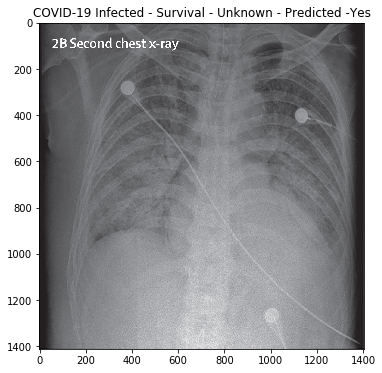

In [167]:
unknown_xray=unlabeled_df.sample()
unknown_img_path=basepath+unknown_xray.sample()['filename'].values[0]
unknown_load = Image.open(unknown_img_path)

f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,1,1)
img_plot = plt.imshow(unknown_load,cmap='gray', vmin=0, vmax=255)
a1.set_title('COVID-19 Infected - Survival - Unknown - Predicted -Yes')

In [123]:
'''
Get out of set validation image - Unlabeled from dataset 1
'''
val_images=get_validation_image(unlabeled_df,basepath)
prob_scores_classes=model_cnn.predict_generator(val_images,steps=235/50)
predicted_classes=list(pd.DataFrame(prob_scores_classes).idxmax(axis=1))
survival_rate=sum(predicted_classes)/len(predicted_classes)
death_rate=1-survival_rate
print('\n\nResults of Dataset 1 (Out of set data)')
print('Survival Rate for COVID-19 patients: {}'.format(survival_rate*100))
print('Death Rate for COVID-19 patients: {}'.format(death_rate*100))

Found 235 validated image filenames.


Results of Dataset 1 (Out of set data)
Survival Rate for COVID-19 patients: 78.72340425531915
Death Rate for COVID-19 patients: 21.276595744680847


In [126]:
'''

Comparing results of COVID-19 X-Ray images, Normal X-Ray images, and Pneumonia X-Ray images (Dataset 2)

'''
basepath_dataset2="C:/Users/dhrupal/covid_hack/576013_1042828_bundle_archive/COVID-19 Radiography Database/"

'''
COVID-19
'''
list_of_covid_files=[]
for i in range(1,220):
    if i<134:
        list_of_covid_files.append("COVID-19 ({}).png".format(i))
    else:
        list_of_covid_files.append("COVID-19({}).png".format(i))
covid_filenames_df=pd.DataFrame(list_of_covid_files,columns=['filename'])
covid_path=basepath_dataset2+'COVID-19/'
covid_out_of_set_validation_img=get_validation_image(covid_filenames_df,covid_path)
prob_covid_dataset2=model_cnn.predict_generator(covid_out_of_set_validation_img,steps=219/50)
predicted_classes_covid_dataset2=list(pd.DataFrame(prob_covid_dataset2).idxmax(axis=1))
survival_rate_covid_dataset2=sum(predicted_classes_covid_dataset2)/len(predicted_classes_covid_dataset2)
death_rate_covid_dataset2=1-survival_rate_covid_dataset2
print('\n\nResults of Dataset 2 (Out of set data)')
print('Survival Rate for COVID-19 Patients: {} '.format(survival_rate_covid_dataset2*100))
print('Death Rate for COVID-19 Patients: {}'.format(death_rate_covid_dataset2*100))

Found 219 validated image filenames.


Results of Dataset 2 (Out of set data)
Survival Rate for COVID-19 Patients: 81.27853881278538 
Death Rate for COVID-19 Patients: 18.721461187214615


Text(0.5, 1.0, 'Dataset 2 - COVID-19(159).png - Survival - Unknown - Predicted -Yes')

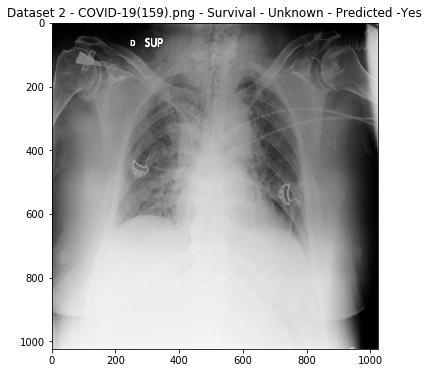

In [187]:
unknown_xray_2=covid_filenames_df.sample()
unknown_img_path_2=covid_path+unknown_xray_2.sample()['filename'].values[0]
unknown_load_2 = Image.open(unknown_img_path_2)

f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,1,1)
img_plot = plt.imshow(unknown_load_2,cmap='gray', vmin=0, vmax=255)
a1.set_title('Dataset 2 - {} - Survival - Unknown - Predicted -Yes'.format(unknown_xray_2.sample()['filename'].values[0]))

In [174]:
'''
NORMAL
'''
list_of_normal_files=[]
for i in range(1,1342):
    list_of_normal_files.append("NORMAL ({}).png".format(i))
normal_filenames_df=pd.DataFrame(list_of_normal_files,columns=['filename'])
normal_path=basepath_dataset2+'NORMAL/'
normal_out_of_set_validation_img=get_validation_image(normal_filenames_df,normal_path)
prob_normal_dataset2=model_cnn.predict_generator(normal_out_of_set_validation_img,steps=1341/50)
predicted_classes_normal_dataset2=list(pd.DataFrame(prob_normal_dataset2).idxmax(axis=1))
survival_rate_normal_dataset2=sum(predicted_classes_normal_dataset2)/len(predicted_classes_normal_dataset2)
death_rate_normal_dataset2=1-survival_rate_normal_dataset2

print('Survival Rate for people in Normal Condition: {}'.format(survival_rate_normal_dataset2*100))
print('Death Rate for people in Normal Condition: {}'.format(death_rate_normal_dataset2*100))

Found 1341 validated image filenames.
Survival Rate for people in Normal Condition: 100.0
Death Rate for people in Normal Condition: 0.0


Text(0.5, 1.0, 'Dataset 2 - NORMAL (623).png - Survival - Yes')

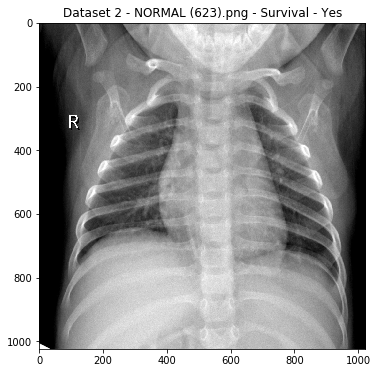

In [188]:
normal_xray_2=normal_filenames_df.sample()
normal_img_path_2=normal_path+normal_xray_2.sample()['filename'].values[0]
normal_load_2 = Image.open(normal_img_path_2)

f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,1,1)
img_plot = plt.imshow(normal_load_2,cmap='gray', vmin=0, vmax=255)
a1.set_title('Dataset 2 - {} - Survival - Yes'.format(normal_xray_2.sample()['filename'].values[0]))

In [129]:
'''
Viral Pneumonia
'''
list_of_pneumonia_files=[]
for i in range(1,1346):
    list_of_pneumonia_files.append("Viral Pneumonia ({}).png".format(i))
pneumonia_filenames_df=pd.DataFrame(list_of_pneumonia_files,columns=['filename'])
pneumonia_path=basepath_dataset2+'Viral Pneumonia/'

pneumonia_out_of_set_validation_img=get_validation_image(pneumonia_filenames_df,pneumonia_path)
prob_pneumonia_dataset2=model_cnn.predict_generator(pneumonia_out_of_set_validation_img,steps=1346/50)
predicted_classes_pneumonia_dataset2=list(pd.DataFrame(prob_pneumonia_dataset2).idxmax(axis=1))
survival_rate_pneumonia_dataset2=sum(predicted_classes_pneumonia_dataset2)/len(predicted_classes_pneumonia_dataset2)
death_rate_pneumonia_dataset2=1-survival_rate_pneumonia_dataset2
print('Survival Rate for Viral Pneumonia Patients: {}'.format(survival_rate_pneumonia_dataset2*100))
print('Death Rate for Viral Pneumonia Pantients: {}'.format(death_rate_pneumonia_dataset2*100))

Found 1345 validated image filenames.
Survival Rate for Viral Pneumonia Patients: 97.69516728624535
Death Rate for Viral Pneumonia Pantients: 2.3048327137546454


Text(0.5, 1.0, 'Dataset 2 - Viral Pneumonia (1096).png - Survival - Yes')

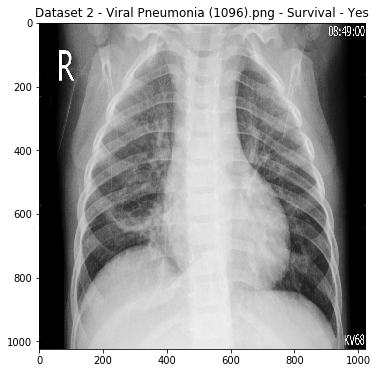

In [189]:
pneumonia_xray_2=pneumonia_filenames_df.sample()
pneumonia_img_path_2=pneumonia_path+pneumonia_xray_2.sample()['filename'].values[0]
pneumonia_load_2 = Image.open(pneumonia_img_path_2)

f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,1,1)
img_plot = plt.imshow(pneumonia_load_2,cmap='gray', vmin=0, vmax=255)
a1.set_title('Dataset 2 - {} - Survival - Yes'.format(pneumonia_xray_2.sample()['filename'].values[0]))